# Deney Sonuçları ve Değerlendirme

Bu bölümde, Yöntem 1 (Custom CNN) ve Yöntem 2 (Transfer Learning) modellerinin eğitim süreçleri, performans metrikleri (Accuracy, Loss, Precision, Recall, F1-Score) ve karmaşıklık matrisleri sunulmaktadır. Ayrıca, gerçek zamanlı demo sırasında elde edilen Kare Başına Saniye (FPS) değerleri de dahil edilmiştir.

Class names detected: ['Ahegao', 'Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']
Number of classes detected: 6
Found 13935 images belonging to 6 classes.
Test generator created with 13935 images.
LOAD AND EVALUATE MODEL
Loading Custom CNN model from: best_custom_model.h5


C:\Users\Asus Vivobook\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Evaluating Model: Custom CNN
Test Loss: 0.4839
Test Accuracy: 0.8087

Classification Report:
               precision    recall  f1-score   support

      Ahegao       0.85      0.97      0.91       594
       Angry       0.73      0.83      0.77      1196
       Happy       0.97      0.91      0.94      3635
     Neutral       0.75      0.74      0.74      3839
         Sad       0.76      0.75      0.75      3616
    Surprise       0.75      0.82      0.79      1055

    accuracy                           0.81     13935
   macro avg       0.80      0.84      0.82     13935
weighted avg       0.81      0.81      0.81     13935



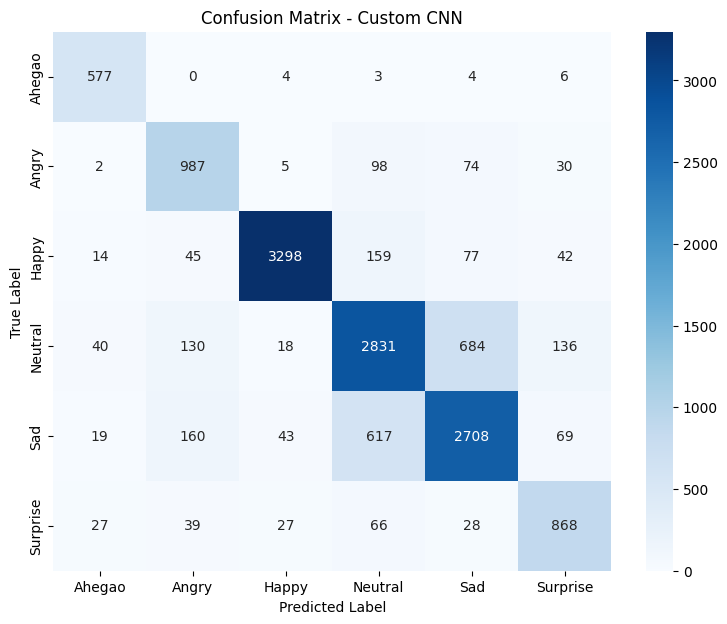

Total samples in Confusion Matrix: 13935
Total samples in True Labels (y_true / Classification Report support sum): 13935

Script execution finished.


In [1]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report, confusion_matrix


PROCESSED_DATASET_PATH = Path('./processed_dataset')


MODEL_IMG_SIZE = (48, 48) 
BATCH_SIZE = 32


CLASS_NAMES = sorted([item.name for item in PROCESSED_DATASET_PATH.iterdir() if item.is_dir()])
NUM_CLASSES = len(CLASS_NAMES)
print("Class names detected:", CLASS_NAMES)
print(f"Number of classes detected: {NUM_CLASSES}")


test_generator = None
if NUM_CLASSES > 0:
    test_datagen = ImageDataGenerator(rescale=1./255) 
    
    try:
        test_generator = test_datagen.flow_from_directory(
            PROCESSED_DATASET_PATH,
            target_size=MODEL_IMG_SIZE, 
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=False 
        )
        print(f"Test generator created with {test_generator.samples} images.")
    except Exception as e:
        print(f"ERROR: Failed to create test generator: {e}")
        test_generator = None
else:
    print("No classes found, skipping test generator creation.")


def evaluate_model_performance(model, generator, model_name, class_names):
    print(f"\nEvaluating Model: {model_name}")
    
    loss, accuracy = model.evaluate(generator, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    
    y_pred_probs = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1) 
    y_true = generator.classes              

    report_str = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
    print("\nClassification Report:\n", report_str)

    cm_array = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(9, 7))
    sns.heatmap(cm_array, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    total_samples_in_cm = cm_array.sum()
    total_samples_in_y_true = len(y_true)

    print(f"Total samples in Confusion Matrix: {total_samples_in_cm}")
    print(f"Total samples in True Labels (y_true / Classification Report support sum): {total_samples_in_y_true}")


CUSTOM_CNN_MODEL_PATH = 'best_custom_model.h5' 


print("LOAD AND EVALUATE MODEL")



if os.path.exists(CUSTOM_CNN_MODEL_PATH) and test_generator: 
    print(f"Loading Custom CNN model from: {CUSTOM_CNN_MODEL_PATH}")
    try:
        loaded_custom_cnn_model = load_model(CUSTOM_CNN_MODEL_PATH)
        evaluate_model_performance(loaded_custom_cnn_model, test_generator, "Custom CNN", CLASS_NAMES)
    except Exception as e:
        print(f"ERROR: An issue occurred while loading or evaluating the Custom CNN model: {e}")
else:
    print(f"Custom CNN model ('{CUSTOM_CNN_MODEL_PATH}') not found or test generator not available. Evaluation skipped.")

print("\nScript execution finished.")


In [ ]:
print("BÖLÜM: KAMERA İLE OTOMATİK YÜZ TANIMA VE TAHMİN")


import os
import time

# Haar Cascade yolunu tam belirtelim
FACE_CASCADE_PATH = os.path.join(os.getcwd(), 'haarcascade_frontalface_default.xml')

face_cascade = cv2.CascadeClassifier(FACE_CASCADE_PATH)

if face_cascade.empty():
    print(f"HATA: Haar Cascade XML dosyası ('{FACE_CASCADE_PATH}') bulunamadı. Kamera testi yapılamıyor.")
else:
    CUSTOM_CNN_MODEL_PATH = 'best_custom_model.h5'
    demo_model = None
    
    if 'loaded_custom_cnn_model' in locals() and loaded_custom_cnn_model is not None:
        demo_model = loaded_custom_cnn_model
        print("Demo için Custom CNN modeli (bellekten) yüklendi.")
    else:
        try:
            demo_model = load_model(CUSTOM_CNN_MODEL_PATH)
            print(f"Demo için '{CUSTOM_CNN_MODEL_PATH}' modeli diskten yüklendi.")
        except Exception as e:
            print(f"Model yüklenirken hata oluştu: {e}")

    if demo_model is None:
        print("Model yüklenemediği için kamera demosu atlanıyor.")
    else:
        cap = cv2.VideoCapture(0)
        if not cap.isOpened():
            print("HATA: Kamera açılamadı. Lütfen kameranızın bağlı ve çalışır durumda olduğundan emin olun.")
        else:
            prev_frame_time = 0
            
            while True:
                ret, frame = cap.read()
                if not ret:
                    print("Kareden okuma başarısız oldu, çıkılıyor...")
                    break

                new_frame_time = time.time()
                time_diff = new_frame_time - prev_frame_time
                fps = 1 / time_diff if time_diff > 0 else 0
                prev_frame_time = new_frame_time

                fps_text = f"FPS: {int(fps)}"
                cv2.putText(frame, fps_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                            1, (0, 255, 0), 2)

                gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

                faces = face_cascade.detectMultiScale(
                    gray_frame,
                    scaleFactor=1.1,
                    minNeighbors=5,
                    minSize=(30, 30)
                )

                for (x, y, w, h) in faces:
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

                    face_roi = gray_frame[y:y+h, x:x+w]
                    resized_face = cv2.resize(face_roi, MODEL_IMG_SIZE)

                    input_face = np.stack([resized_face]*3, axis=-1)
                    input_face = np.expand_dims(input_face, axis=0) / 255.0

                    predictions = demo_model.predict(input_face, verbose=0)
                    emotion_index = np.argmax(predictions[0])
                    predicted_emotion_label = CLASS_NAMES[emotion_index]
                    confidence = predictions[0][emotion_index] * 100

                    text = f"{predicted_emotion_label}: {confidence:.2f}%"
                    cv2.putText(frame, text, (x, y - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

                cv2.imshow('Real-Time Emotion Recognition', frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

            cap.release()
            cv2.destroyAllWindows()



BÖLÜM: KAMERA İLE OTOMATİK YÜZ TANIMA VE TAHMİN
Demo için Custom CNN modeli (bellekten) yüklendi.
